# Compute global annual anomalies

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.signal import detrend
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
import xarray as xr
import intake
import pprint 
import util 
import os

## define functions
def calendar_check_new(model):
    calendarfile = '../Processed_data/Calendars/' + model + '_calendars.txt'
    cal_df = pd.read_table(calendarfile, index_col=0, sep = ' ')
    calendars_used = cal_df['calendar'].drop_duplicates()
    # I think 365 days calendar must be the same as noleap
    return calendars_used.values[0]

def calendar_check_old(model):
    # Time formats for piControl, found from manual check:
    if model in ['TaiESM1', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'FGOALS-f3-L', 'FGOALS-g3', 'CanESM5', 'CanESM5-CanOE', 'E3SM-1-0', 'E3SM-1-1', 'E3SM-1-1-ECA', 'FIO-ESM-2-0', 'INM-CM4-8', 'INM-CM5-0', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'GISS-E2-2-G', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorCPM1', 'NorESM1-F', 'NorESM2-LM', 'NorESM2-MM', 'GFDL-CM4', 'SAM0-UNICON', 'GFDL-ESM4', 'CIESM', 'MCM-UA-1-0']:
        ds_calendar = 'noleap'
    elif model in ['CNRM-CM6-1', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'NESM3']:
        ds_calendar = 'gregorian'
    elif model in ['AWI-CM-1-1-MR', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR']:
        ds_calendar = 'proleptic_gregorian'
    elif model in ['UKESM1-0-LL', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'CNRM-ESM2-1', 'KACE-1-0-G', 'MRI-ESM2-0']:
        ds_calendar = '360_day'
        if model in ['CNRM-ESM2-1', 'MRI-ESM2-0']:
            print('piControl is 360_day, the other experiments unknown')
    elif model in ['IITM-ESM']:
        ds_calendar = 'Julian'
    elif model in ['AWI-ESM-1-1-LR', 'CNRM-CM6-1-HR', 'EC-Earth3', 'EC-Earth3-LR']:
        #ds_calendar = 'datetime64'
        print('not 100% sure what calendar this model has, but a guess is made based on other models from same institution')
        if model in ['EC-Earth3', 'EC-Earth3-LR', 'AWI-ESM-1-1-LR']:
            print('calendar is likely proleptic gregorian')
            ds_calendar = 'proleptic_gregorian'
        elif model in ['CNRM-CM6-1-HR']:
            print('calendar is likely gregorian')
            ds_calendar = 'gregorian'
    return ds_calendar

# function copied from: http://xarray.pydata.org/en/stable/examples/monthly-means.html
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap


# days per month:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], # I assume this is the same as noleap
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'julian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], ##### I think this should be correct
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
      }

# days per year
def dpy(model, start_year, end_year):
    ds_calendar = calendar_check_new(model) 
    leap_boolean = [leap_year(year, calendar = ds_calendar) for year in range(start_year, end_year)]
    leap_int = np.multiply(leap_boolean,1)
    
    noleap_dpy = np.array(dpm[ds_calendar]).sum()
    leap_dpy = noleap_dpy + leap_int
    return leap_dpy  

## Find models where we have global annual means, but no anomalies:

In [113]:
model_mean_names = [ f.name for f in os.scandir('../Processed_data/Global_annual_means/') if f.is_dir() and f.name !='.ipynb_checkpoints']
model_anom_names = [ f.name for f in os.scandir('../Processed_data/Global_annual_anomalies/') if f.is_dir() and f.name !='.ipynb_checkpoints']

no_anoms_yet = set(model_mean_names)-set(model_anom_names)
for model in no_anoms_yet:
    mean_exp = [ f.name for f in os.scandir('../Processed_data/Global_annual_means/' + model) if f.is_dir() and f.name !='.ipynb_checkpoints']
    print(model, ' ', mean_exp)
    
    

FIO-ESM-2-0   ['ssp585', 'piControl', 'abrupt-4xCO2', 'ssp245', 'historical', '1pctCO2', 'ssp126']


## Find models where we have some anomalies, but are missing some experiments/members

In [100]:
for model in model_anom_names:
    #print(model)
    mean_exp = [ f.name for f in os.scandir('../Processed_data/Global_annual_means/' + model) if f.is_dir() and f.name !='.ipynb_checkpoints']
    anom_exp = [ f.name for f in os.scandir('../Processed_data/Global_annual_anomalies/' + model) if f.is_dir() and f.name !='.ipynb_checkpoints']
    diff = set(mean_exp) - set(anom_exp)
    if len(diff)>0:
        print(model, 'has no anomalies for', diff)
    else:
        #print('test')
        for exp in anom_exp: # do we have all members?
            # compare number of files in folders
            anom_exp_members = [ f.name for f in os.scandir('../Processed_data/Global_annual_means/' + model + '/' + exp) if f.name !='.ipynb_checkpoints']
            mean_exp_members = [ f.name for f in os.scandir('../Processed_data/Global_annual_means/' + model + '/' + exp) if f.name !='.ipynb_checkpoints']
            diff_members = set(mean_exp_members) - set(anom_exp_members)
            if len(diff_members)>0:
                print('Anomalies not computed for ', diff_members, 'members of', model, exp)
            #else:
                #print('test')

NorESM2-LM has no anomalies for {'piClim-4xCO2', 'piClim-histall', 'piClim-control'}
ACCESS-ESM1-5 has no anomalies for {'piClim-4xCO2', 'piClim-control'}
HadGEM3-GC31-LL has no anomalies for {'piClim-4xCO2', 'piClim-histall', 'piClim-control'}
CESM2 has no anomalies for {'piClim-4xCO2', 'piClim-control'}
NorCPM1 has no anomalies for {'historical'}
CESM2-WACCM has no anomalies for {'piClim-control'}
MPI-ESM1-2-LR has no anomalies for {'piClim-4xCO2', 'piClim-control'}
GISS-E2-1-G has no anomalies for {'piClim-4xCO2', 'piClim-histall', 'piClim-control'}
CNRM-CM6-1 has no anomalies for {'piClim-4xCO2', 'piClim-histall', 'piClim-control'}
GISS-E2-1-H has no anomalies for {'1pctCO2', 'historical'}
MRI-ESM2-0 has no anomalies for {'piClim-4xCO2', 'piClim-control'}
EC-Earth3 has no anomalies for {'piClim-4xCO2', 'piClim-control'}
IPSL-CM6A-LR has no anomalies for {'piClim-4xCO2', 'piClim-histall', 'piClim-control'}
ACCESS-CM2 has no anomalies for {'piClim-4xCO2', 'piClim-control'}
MIROC6 has

## Choose model and experiment

In [180]:
#model = 'FGOALS-f3-L'
#model = 'GISS-E2-1-H'
#model = 'KIOST-ESM'
model = 'GISS-E2-1-H'

#exp = 'piControl'
exp = 'abrupt-4xCO2'
#exp = 'abrupt-2xCO2'
#exp = 'abrupt-0p5xCO2'
#exp = '1pctCO2'

#exp = 'historical'
#exp = 'ssp126'
#exp = 'ssp245'
#exp = 'ssp370'
#exp = 'ssp585'

In [181]:
branch_time_file = '../Processed_data/Branch_times/' + model + '_branch_times.txt'
table = pd.read_table(branch_time_file,index_col=0, sep = ' ')
#pd.set_option('display.max_rows', None)
pd.set_option('display.min_rows', 15)
table

,model,exp,member,parent_experiment_id,parent_variant_id,branch_time_in_child,branch_time_in_parent,parent_time_units,branch_method
0,GISS-E2-1-H,1pctCO2,r1i1p1f1,piControl,r1i1p1f1,0.0,0.0,days since 3180-1-1,standard
1,GISS-E2-1-H,abrupt-2xCO2,r1i1p1f1,piControl,r1i1p1f1,0.0,0.0,days since 3180-1-1,standard
2,GISS-E2-1-H,abrupt-4xCO2,r1i1p1f1,piControl,r1i1p1f1,0.0,0.0,days since 3180-1-1,standard
3,GISS-E2-1-H,abrupt-4xCO2,r1i1p3f1,piControl,r1i1p3f1,0.0,0.0,days since 2000-1-1,standard
4,GISS-E2-1-H,historical,r10i1p1f1,piControl,r1i1p1f1,0.0,65700.0,days since 3180-1-1,standard
5,GISS-E2-1-H,historical,r1i1p1f1,piControl,r1i1p1f1,0.0,0.0,days since 3180-1-1,standard
6,GISS-E2-1-H,historical,r1i1p1f2,piControl,r1i1p1f2,0.0,0.0,days since 4000-1-1,standard
7,GISS-E2-1-H,historical,r1i1p3f1,piControl,r1i1p3f1,0.0,0.0,days since 2000-1-1,standard
8,GISS-E2-1-H,historical,r1i1p5f1,piControl,r1i1p5f1,0.0,0.0,days since 2000-1-1,standard
9,GISS-E2-1-H,historical,r2i1p1f1,piControl,r1i1p1f1,0.0,7300.0,days since 3180-1-1,standard


piControl_start_year 3180
0.0
0
days difference: 0.0
differences not equal to 0 indicate wrong calendar assumptions or branch dates not equal to the start of a new year
path already exists. Make sure no data in it are written over erroneously
piControl_start_year 3180
0.0
0
days difference: 0.0
differences not equal to 0 indicate wrong calendar assumptions or branch dates not equal to the start of a new year


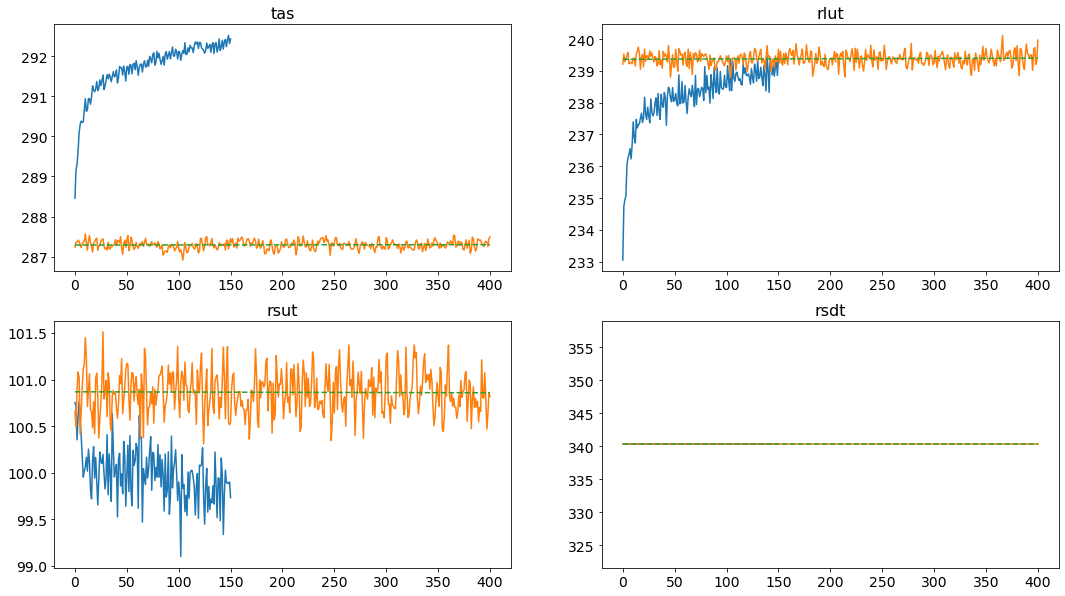

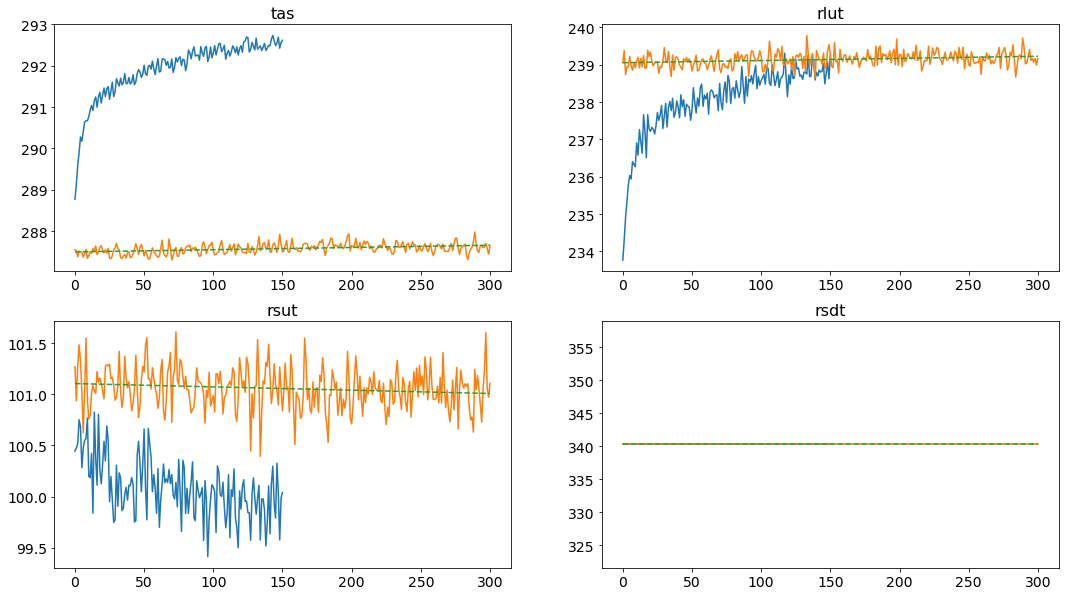

In [183]:
plot_absolute_values = True
plot_anomalies = False
save_results = True
#save_results = False

expgroup0 = ['piControl']
expgroup1 = ['abrupt-4xCO2', 'abrupt-2xCO2', 'abrupt-0p5xCO2', '1pctCO2']
expgroup2 = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

piControl_path = '../Processed_data/Global_annual_means/' + model + '/piControl/'
exp_path = '../Processed_data/Global_annual_means/' + model + '/' + exp + '/'

exptable = table.loc[table['exp'] == exp]
available_members = exptable['member'].values

for member in available_members:
    member_df = exptable.loc[exptable['member'] == member]

    # load exp data
    exp_filename = model + '_' + exp + '_' + member + '_means.txt'
    exp_data = pd.read_table(exp_path + exp_filename, index_col=0, sep = ',')
    
    if plot_absolute_values == True:
        fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [18,10]); axes = np.reshape(ax, 4)
    if plot_anomalies == True:
        fig, ax2 = plt.subplots(nrows = 2, ncols = 2, figsize = [18,10]); axes2 = np.reshape(ax2, 4)

    if exp in expgroup1 or exp in expgroup2:
        if exp in expgroup1 or exp == 'historical':
            branch_time_days = member_df['branch_time_in_parent'].values[0]
            piControl_member = member_df['parent_variant_id'].values[0] 
        elif exp in expgroup2: # then ssp. check branch for historical parent only
            # find historical parent member 
            parent_member = member_df['parent_variant_id'].values[0]
            parent_table = table.loc[table['exp'] == 'historical']
            parent_df = parent_table.loc[parent_table['member'] == parent_member]
            branch_time_days = parent_df['branch_time_in_parent'].values[0]
            piControl_member = parent_df['parent_variant_id'].values[0]
        
        # correct the info loaded above for some models/exps/members:
        if model in ['MPI-ESM1-2-HR', 'BCC-CSM2-MR', 'INM-CM5-0', 'MPI-ESM-1-2-HAM'] and exp in expgroup2:
            piControl_member = 'r1i1p1f1' # overwrite info from file, which seems to be wrong
        if model in ['NorESM2-LM'] and exp == 'ssp370':
            parent_member = member # overwrite info in file which is likely wrong
            parent_df = parent_table.loc[parent_table['member'] == parent_member]
            branch_time_days = parent_df['branch_time_in_parent'].values[0]
            piControl_member = parent_df['parent_variant_id'].values[0]
        if model in ['IPSL-CM6A-LR'] and exp == 'historical' and member == 'r32i1p1f1': 
            piControl_member = 'r1i1p1f1' # overwrite info saying that piControl member is also 'r32i1p1f1'
        if model in ['CNRM-CM6-1', 'CNRM-ESM2-1'] and exp in ['abrupt-4xCO2', '1pctCO2']:
            piControl_member = 'r1i1p1f2' # this is the only control run available
            # many CNRM-CM6-1 historical branch times are after the end of picontrol in , but I find no errata info about this. Maybe a later period of piControl is just not available
        if model in ['NESM3'] and exp == 'historical' and member == 'r3i1p1f1':
            piControl_member = 'r1i1p1f1' # this is the only control run available
        if model in ['CIESM']: #and exp in expgroup1:
            piControl_member = 'r1i1p1f1' # this is the only control run available
        
        # load piControl values. 
        piControl_filename = model + '_piControl_' + piControl_member + '_means.txt'
        piControl_data = pd.read_table(piControl_path + piControl_filename, index_col=0, sep = ',')
        
        piControl_start_year = int(table.loc[table['parent_experiment_id'] == 'piControl']['parent_time_units'][0][11:15]) # wrong for several models. Sometimes the branch_time_in_parent is not 0, and makes the startyear correct.
        print('piControl_start_year', piControl_start_year)
        days_table = np.append([0],np.cumsum(dpy(model,piControl_start_year,piControl_start_year+1500)))    
        # find index of element closest to branch_time_days
        year_since_piControl_start = (np.abs(days_table - branch_time_days)).argmin()
        if model in ['BCC-CSM2-MR', 'BCC-ESM1'] and exp in expgroup2: # models with branch time given in years instead of days
            year_since_piControl_start = int(branch_time_days - piControl_start_year)
            print('year_since_piControl_start is', year_since_piControl_start)
        elif model in ['CAMS-CSM1-0']: # branch times given in years instead of days for all experiments except piControl
            piControl_start_year = 2900
            year_since_piControl_start = int(branch_time_days - piControl_start_year)
            print('year_since_piControl_start is', year_since_piControl_start)
        elif model in ['NorESM2-LM']:
            piControl_start_year = 1600
            if exp in expgroup1:
                year_since_piControl_start = 0 # because 4xCO2, 1pctCO2 branch time is the same as piControl branch time
            elif exp in expgroup2: # measure branch time relative to r1 member
                if member == 'r1i1p1f1':
                    year_since_piControl_start = 0
                else:
                    days_table = np.append([0],np.cumsum(dpy(model,piControl_start_year,piControl_start_year+500)))
                    branch_time_days = branch_time_days - 430335
                    # find index of element closest to branch_time_days
                    year_since_piControl_start = (np.abs(days_table - branch_time_days)).argmin()
                    print(member)
                    print(year_since_piControl_start)
                    print('days difference:', days_table[year_since_piControl_start] - branch_time_days)
        elif model in ['NorESM2-MM']:
            piControl_start_year = 1200
            year_since_piControl_start = 0 # because 4xCO2 branch time is the same as piControl branch time
        elif model in ['UKESM1-0-LL']:
            piControl_start_year = 1960
            #if exp in expgroup1:
            #    branch_time_days = branch_time_days - 39600   
            #    year_since_piControl_start = 0
            if exp in expgroup1 or exp in expgroup2:
                days_table = np.append([0],np.cumsum(dpy(model,piControl_start_year,piControl_start_year+1000)))
                branch_time_days = branch_time_days - 39600
                # find index of element closest to branch_time_days
                year_since_piControl_start = (np.abs(days_table - branch_time_days)).argmin()
                print(member)
                print(year_since_piControl_start)
                print('days difference:', days_table[year_since_piControl_start] - branch_time_days)
        elif model in ['GFDL-CM4']:
            piControl_start_year = 151 # found from manual check. Branch info is clearly wrong, since it lists different time units for piControl
            if exp == 'abrupt-4xCO2':
                year_since_piControl_start = 0
            elif exp in expgroup2:
                year_since_piControl_start = 100 # probably?
        elif model == 'CanESM5': 
            if exp in expgroup1:
                if exp == '1pctCO2':
                    if int(member[-3]) == 1:
                        branch_time_days = branch_time_days - 1223115 
                    elif int(member[-3]) == 2:
                        branch_time_days = branch_time_days - 1350500
                    year_since_piControl_start = (np.abs(days_table - branch_time_days)).argmin()
                    print(year_since_piControl_start)
                    print('days difference:', days_table[year_since_piControl_start] - branch_time_days)
                else:
                    year_since_piControl_start = 0 # because 4xCO2 branch time is the same as piControl branch time
            elif exp in expgroup2: # measure branch time relative to r1 member
                piControl_start_year = 5201
                days_table = np.append([0],np.cumsum(dpy(model,piControl_start_year,piControl_start_year+2000)))  
                if int(member[-3]) == 1:
                    branch_time_days = branch_time_days - 1223115 
                elif int(member[-3]) == 2:
                    branch_time_days = branch_time_days - 1350500
                # find index of element closest to branch_time_days
                year_since_piControl_start = (np.abs(days_table - branch_time_days)).argmin()
                print(member)
                print(year_since_piControl_start)
                print('days difference:', days_table[year_since_piControl_start] - branch_time_days)
        elif model in ['CanESM5-CanOE']:
            if exp in expgroup1:
                year_since_piControl_start = 0 # because 4xCO2 branch time is the same as piControl branch time
            #elif exp == 'historical':
            elif exp in expgroup2:
                piControl_start_year = 5550
                days_table = np.append([0],np.cumsum(dpy(model,piControl_start_year,piControl_start_year+2000)))  
                branch_time_days = branch_time_days - 1350500
                print('branch_time_days', branch_time_days)
                # find index of element closest to branch_time_days
                year_since_piControl_start = (np.abs(days_table - branch_time_days)).argmin()
                print('year_since_piControl_start', year_since_piControl_start)
        elif model in ['TaiESM1']:
            if exp == '1pctCO2':
                year_since_piControl_start = 701 - 201
            elif exp == 'abrupt-4xCO2':
                year_since_piControl_start = 701 - 201 # if we choose to trust info from branch method rather than branch_time_in_parent. This info seems to be the most correct for other experiments
            elif exp == 'historical':
                year_since_piControl_start = 671 - 201
        elif model in ['EC-Earth3-Veg-LR']:
            if exp in expgroup2:
                branch_time_days = branch_time_days - 164359
                year_since_piControl_start = (np.abs(days_table - branch_time_days)).argmin()
                print('year_since_piControl_start', year_since_piControl_start)
        elif model in ['KIOST-ESM']:
            branch_time_days = branch_time_days - 306445
            year_since_piControl_start = (np.abs(days_table - branch_time_days)).argmin()
            print('year_since_piControl_start', year_since_piControl_start)
        else:
            print(branch_time_days)
            print(days_table[year_since_piControl_start])
            print('days difference:', days_table[year_since_piControl_start] - branch_time_days)
            print('differences not equal to 0 indicate wrong calendar assumptions or branch dates not equal to the start of a new year')
        
    for (i,var) in enumerate(['tas', 'rlut', 'rsut', 'rsdt']):
        ydata = exp_data[var]; 
        # remove possible nan values?
        exp_len = len(exp_data[var])
        if exp in expgroup0:
            # then just subtract a linear trend from all values
            y = exp_data[var]; 
            y = y[np.isnan(y) == False] # needed for some models with several piControl members. 
            # Saved data should be manually checked if different variables exist for different periods
            # because this code makes them all to start at time 0.
            x = np.arange(len(y))
            datarange = np.arange(len(y))
        elif exp in expgroup1:
            y = piControl_data[var] # use all piControl years to determine trend
            y = y[np.isnan(y) == False]
            x = np.arange(len(y))
            #y = piControl_data[var][year_since_piControl_start:(year_since_piControl_start+exp_len)] # Use only years corresponding to exp years
            #x = np.arange(exp_len)
            datarange = year_since_piControl_start + np.arange(exp_len)
        elif exp in expgroup2:
            #x = np.arange(251) # number of years in interval (1850 - 2100)
            y = piControl_data[var] # use all piControl years to determine trend
            y = y[np.isnan(y) == False]
            x = np.arange(len(y))
            #y = piControl_data[var][year_since_piControl_start:(year_since_piControl_start+251)] # Use historical + ssp years (1850 - 2100)
            if exp == 'historical':
                datarange = year_since_piControl_start + np.arange(165)
            else:
                datarange = year_since_piControl_start + np.arange(165,251)
                if model in ['CIESM'] and exp == 'ssp585':
                    ydata = ydata[np.isnan(ydata) == False] # because of an error in the time coordinate of rsdt
                ydata = ydata[:86] # if data exists beyond year 2100, this code excludes them
                if model == 'CAMS-CSM1-0': # stops in 2099
                    datarange = year_since_piControl_start + np.arange(165,250)
                elif model in ['BCC-ESM1', 'MPI-ESM-1-2-HAM']: # ssp370 has only 40 years of data
                    datarange = year_since_piControl_start + np.arange(165,206)


        #if len(y) == len(x):
        #    p1 = np.polyfit(x,y,1)
        #elif len(y) < len(x):
        #    p1 = np.polyfit(x[:len(y)],y,1) # make a fit from the data we have available
        #lintrend = np.polyval(p1,x)
        p1 = np.polyfit(x,y,1)
        lintrend = np.polyval(p1,np.arange(max(len(x), datarange[-1]+1))) # make trend longer than x, in case exp ends later than piControl  
        if exp in expgroup0:
            annual_anomalies = y - lintrend[datarange]
        else:
            annual_anomalies = ydata - lintrend[datarange]
        if var == 'tas':
            # create dataframe for storing anomalies
            exp_anomalies = pd.DataFrame(annual_anomalies.values, columns = [var])
        else:
            df_col = pd.DataFrame(annual_anomalies.values, columns = [var])
            exp_anomalies = pd.merge(exp_anomalies, df_col, left_index=True, right_index=True, how='outer')

        if plot_absolute_values == True: # plot abolute values and trends
            if exp in expgroup0:
                axes[i].plot(datarange, y) # exp data
            else:
                axes[i].plot(datarange, ydata) # exp data
            #axes[i].plot(x[:len(y)], y)
            axes[i].plot(x, y) # piControl
            axes[i].plot(np.arange(len(lintrend)), lintrend, '--') # piControl trend
            #axes[i].plot(x, lintrend[:len(x)]) # piControl trend
            axes[i].set_title(var, fontsize = 16)
            axes[i].tick_params(axis='both',labelsize=14)
        if plot_anomalies == True: # plot anomalies for visual check:
            axes2[i].plot(x, exp_anomalies[var])
            axes2[i].set_title(x, var, fontsize = 16)
            axes2[i].tick_params(axis='both',labelsize=14) 

    if save_results == True:
        filename = model + '_' + exp + '_' + member + '_anomalies.txt'
        #file = os.path.join('../Processed_data/Global_annual_anomalies/', model, exp, filename)
        #if member == available_members[0]: # create directory for first member
        #    os.makedirs(os.path.dirname(file), exist_ok=False)
        #exp_anomalies.to_csv(file)
        filepath = os.path.join('../Processed_data/Global_annual_anomalies/', model, exp)
        if os.path.isdir(filepath) == False:
            os.makedirs(filepath)
        else:
            if member == available_members[0]:
                print('path already exists. Make sure no data in it are written over erroneously')
        exp_anomalies.to_csv(filepath + '/' + filename)
        
        

In [185]:
exp_anomalies

,tas,rlut,rsut,rsdt
0,1.272382,-5.288582,-0.659777,5.684342e-14
1,1.637947,-4.759696,-0.628752,5.684342e-14
2,2.090217,-4.145294,-0.587155,5.684342e-14
3,2.405066,-3.697308,-0.351837,5.684342e-14
4,2.781219,-3.274067,-0.420490,5.684342e-14
5,2.677172,-3.026584,-0.819816,5.684342e-14
6,2.900518,-3.121552,-0.626124,5.684342e-14
...,...,...,...,...
144,5.041920,-0.318684,-1.130940,1.136868e-13
145,4.917805,-0.113128,-1.267244,1.136868e-13
